In [1]:
from matplotlib import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce


In [2]:
pt_projections = pd.read_csv('/data/kebl6672/dpo-toxic-general/toxicity/gemma2_neuron_projections_new.csv')
dpo_projections = pd.read_csv('/data/kebl6672/dpo-toxic-general/toxicity/gemma2_dpo_neuron_projections_new.csv')

pt_cossims = pd.read_csv('/data/kebl6672/dpo-toxic-general/toxicity/gemma2_neuron_cossims_new.csv')
dpo_cosine_similaritys = pd.read_csv('/data/kebl6672/dpo-toxic-general/toxicity/gemma2_dpo_neuron_cossims_new.csv')

In [3]:
# List of DataFrames to merge
dfs = [pt_projections, dpo_projections, pt_cossims, dpo_cosine_similaritys]

# Merge all DataFrames in the list on 'layer_idx' and 'neuron_idx'
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['layer_idx', 'neuron_idx'], how='outer'), dfs)

merged_df.replace([float("inf"), float("-inf")], np.nan, inplace=True)
merged_df.dropna(inplace=True)  # Removes affected rows

merged_df['projection_diff'] = merged_df['pt_projection_value'] - merged_df['dpo_projection_value']
merged_df['activation_diff'] = merged_df['pt_activation_value'] - merged_df['dpo_activation_value']

# Display the first few rows of the DataFrame
print(merged_df.head())

   layer_idx  neuron_idx  pt_projection_value  pt_activation_value  \
0          0           0        -5.960464e-07             0.024658   
1          0           1        -2.896786e-05            -0.011703   
2          0           2         5.602837e-06             0.004879   
3          0           3         4.172325e-07            -0.001812   
4          0           4         3.697872e-04            -0.021820   

   dpo_projection_value  dpo_activation_value  pt_cosine_similarity  \
0              0.000001              0.023514             -0.000066   
1             -0.000042             -0.016098              0.006180   
2              0.000007              0.006229              0.002983   
3              0.000001             -0.007725             -0.000586   
4              0.000381             -0.022552             -0.048981   

   dpo_cosine_similarity  projection_diff  activation_diff  
0               0.000140    -1.728535e-06         0.001144  
1               0.006405     1

##### Compute max and sum of projection

In [4]:
# Calculate the sum of non-negative values of 'projection_diff'
sum_non_negative = merged_df[merged_df['projection_diff'] >= 0]['projection_diff'].sum()

# Calculate the sum of all values of 'projection_diff'
sum_all = merged_df['projection_diff'].sum()

# Print the results
print(f"Sum of non-negative values: {sum_non_negative}")
print(f"Sum of all values: {sum_all}")

Sum of non-negative values: 3.270072817801948
Sum of all values: 0.1269511580467054


In [5]:
# Count rows where projection_diff is positive
positive_count = (merged_df["projection_diff"] > 0).sum()

# Total number of rows
total_count = len(merged_df)

# Compute percentage
percentage_positive = (positive_count / total_count) * 100

print(positive_count)
print(f"Percentage of rows with positive projection_diff: {percentage_positive:.2f}%")


121159
Percentage of rows with positive projection_diff: 50.57%


In [6]:
# Compute total projection difference
total_projection_diff = merged_df["projection_diff"].sum()
print("Total sum of projection_diff:", total_projection_diff)

# Compute per-layer projection difference
per_layer_projection_diff = merged_df.groupby("layer_idx")["projection_diff"].sum()

# Print per-layer results
print("\nPer-layer projection difference:")
print(per_layer_projection_diff)


Total sum of projection_diff: 0.1269511580467054

Per-layer projection difference:
layer_idx
0    -0.000671
1     0.012751
2    -0.003245
3     0.001504
4    -0.004270
5     0.005765
6     0.001775
7    -0.000915
8     0.006097
9     0.007836
10   -0.000053
11   -0.001984
12   -0.001369
13    0.004592
14    0.002062
15   -0.001265
16    0.011035
17    0.006510
18    0.003941
19    0.024145
20   -0.001695
21    0.014372
22    0.034441
23    0.003021
24    0.008292
25   -0.005720
Name: projection_diff, dtype: float64


#### Per-layer projection

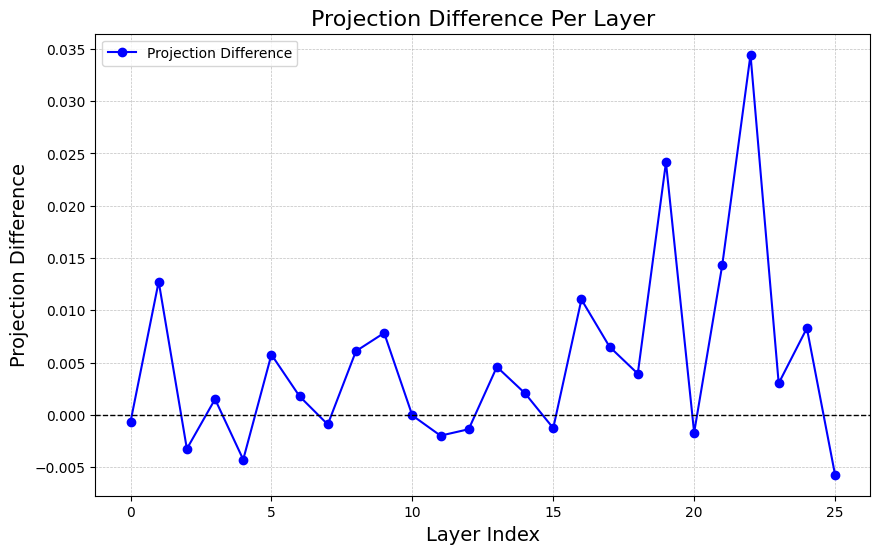

In [4]:
# Compute per-layer projection difference
layer_sums = merged_df.groupby("layer_idx")[["pt_projection_value", "dpo_projection_value"]].sum().reset_index()

layer_sums["projection_diff"] = layer_sums["pt_projection_value"] - layer_sums["dpo_projection_value"]

# Plot the data
plt.figure(figsize=(10, 6))

# Plot Projection Difference
plt.plot(layer_sums["layer_idx"], layer_sums["projection_diff"], label="Projection Difference", marker='o', linestyle='-', color='blue')

# Add a horizontal line at y=0 for reference
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.8)  # Lighter gray grid

# Labels and title
plt.xlabel("Layer Index", fontsize=14)
plt.ylabel("Projection Difference", fontsize=14)
plt.title("Projection Difference Per Layer", fontsize=16)
plt.legend()
plt.grid(True)

# Show plot
plt.show()


#### Per-layer projection plot

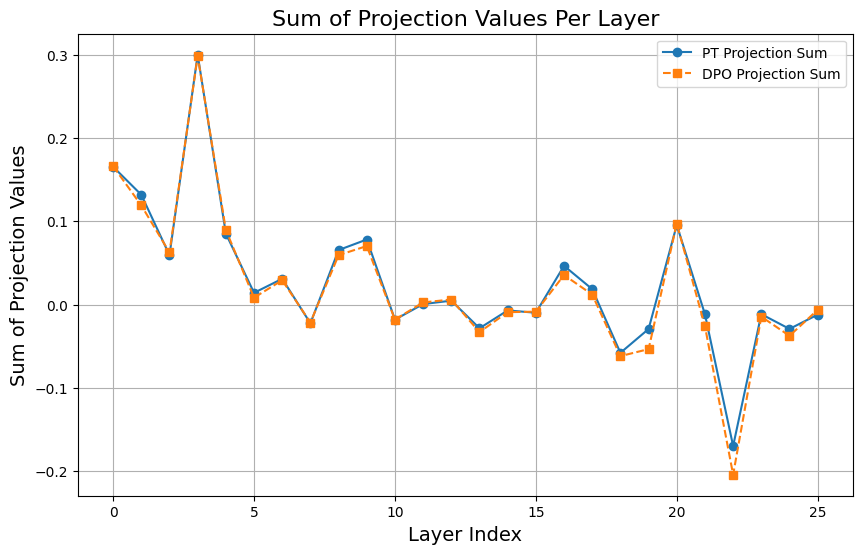

In [8]:
# Group by layer_index and compute the sum for pt_projection_value and dpo_projection_value
layer_sums = merged_df.groupby("layer_idx")[["pt_projection_value", "dpo_projection_value"]].sum().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))

# Plot PT projection sum
plt.plot(layer_sums["layer_idx"], layer_sums["pt_projection_value"], label="PT Projection Sum", marker='o', linestyle='-')

# Plot DPO projection sum
plt.plot(layer_sums["layer_idx"], layer_sums["dpo_projection_value"], label="DPO Projection Sum", marker='s', linestyle='--')

# Labels and title
plt.xlabel("Layer Index", fontsize=14)
plt.ylabel("Sum of Projection Values", fontsize=14)
plt.title("Sum of Projection Values Per Layer", fontsize=16)
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [14]:
df = merged_df

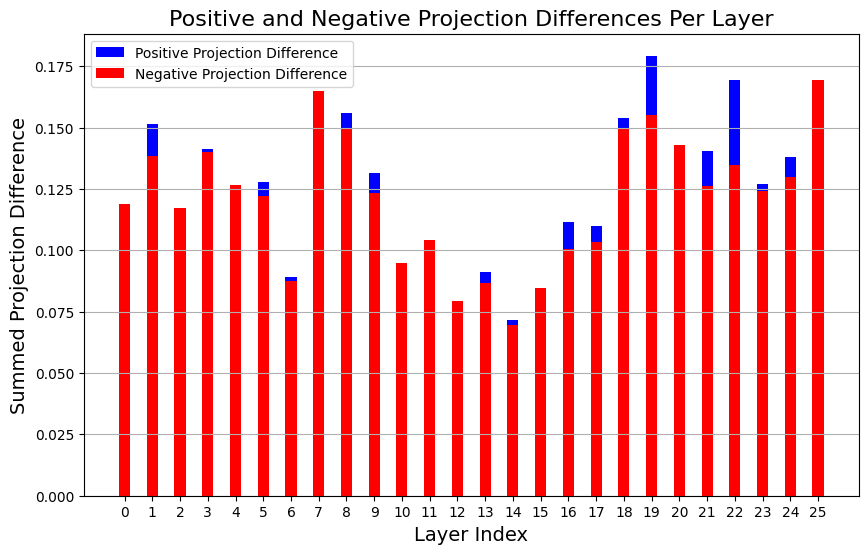

In [15]:
# Compute per-layer sum of positive and negative projection differences separately
layer_sums = df.groupby("layer_idx")[["pt_projection_value", "dpo_projection_value"]].sum().reset_index()

# Compute projection difference at the neuron level before summing at the layer level
df["projection_diff"] = df["pt_projection_value"] - df["dpo_projection_value"]

# Aggregate separately for positive and negative projection differences
positive_projection_sums = df[df["projection_diff"] > 0].groupby("layer_idx")["projection_diff"].sum().reset_index()
negative_projection_sums = df[df["projection_diff"] < 0].groupby("layer_idx")["projection_diff"].sum().abs().reset_index()

# Merge with the main layer index to ensure all layers are represented
layer_sums = layer_sums[["layer_idx"]].merge(positive_projection_sums, on="layer_idx", how="left").merge(
    negative_projection_sums, on="layer_idx", how="left", suffixes=("_positive", "_negative")
)

# Fill NaN values with 0 (for layers with no positive or negative values)
layer_sums.fillna(0, inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot positive and negative projection differences as side-by-side bars
width = 0.4  # Bar width for better visibility

plt.bar(layer_sums["layer_idx"], layer_sums["projection_diff_positive"], width=width, label="Positive Projection Difference", color="blue")
plt.bar(layer_sums["layer_idx"], layer_sums["projection_diff_negative"], width=width, label="Negative Projection Difference", color="red")

# Labels and title
plt.xlabel("Layer Index", fontsize=14)
plt.ylabel("Summed Projection Difference", fontsize=14)
plt.title("Positive and Negative Projection Differences Per Layer", fontsize=16)
plt.xticks(layer_sums["layer_idx"])  # Ensure all layers are visible on x-axis
plt.legend()
plt.grid(axis="y")

# Show plot
plt.show()

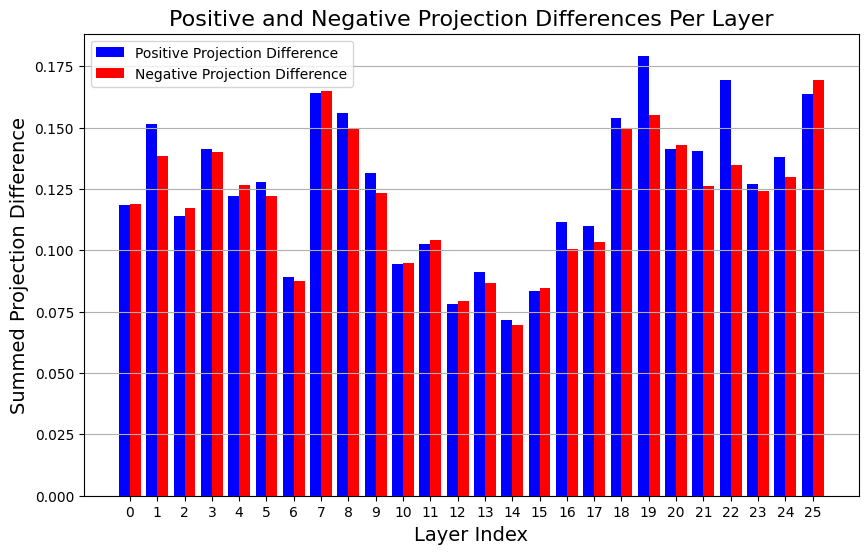

In [16]:
# Compute per-layer sum of positive and negative projection differences separately
layer_sums = df.groupby("layer_idx")[["pt_projection_value", "dpo_projection_value"]].sum().reset_index()

# Compute projection difference at the neuron level before summing at the layer level
df["projection_diff"] = df["pt_projection_value"] - df["dpo_projection_value"]

# Aggregate separately for positive and negative projection differences
positive_projection_sums = df[df["projection_diff"] > 0].groupby("layer_idx")["projection_diff"].sum().reset_index()
negative_projection_sums = df[df["projection_diff"] < 0].groupby("layer_idx")["projection_diff"].sum().abs().reset_index()

# Merge with the main layer index to ensure all layers are represented
layer_sums = layer_sums[["layer_idx"]].merge(positive_projection_sums, on="layer_idx", how="left").merge(
    negative_projection_sums, on="layer_idx", how="left", suffixes=("_positive", "_negative")
)

# Fill NaN values with 0 (for layers with no positive or negative values)
layer_sums.fillna(0, inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot positive and negative projection differences as side-by-side bars
width = 0.4  # Bar width for better visibility

plt.bar(layer_sums["layer_idx"] - width/2, layer_sums["projection_diff_positive"], width=width, label="Positive Projection Difference", color="blue")
plt.bar(layer_sums["layer_idx"] + width/2, layer_sums["projection_diff_negative"], width=width, label="Negative Projection Difference", color="red")

# Labels and title
plt.xlabel("Layer Index", fontsize=14)
plt.ylabel("Summed Projection Difference", fontsize=14)
plt.title("Positive and Negative Projection Differences Per Layer", fontsize=16)
plt.xticks(layer_sums["layer_idx"])  # Ensure all layers are visible on x-axis
plt.legend()
plt.grid(axis="y")

# Show plot
plt.show()

##### Cumulative sum plot

In [5]:
df = merged_df

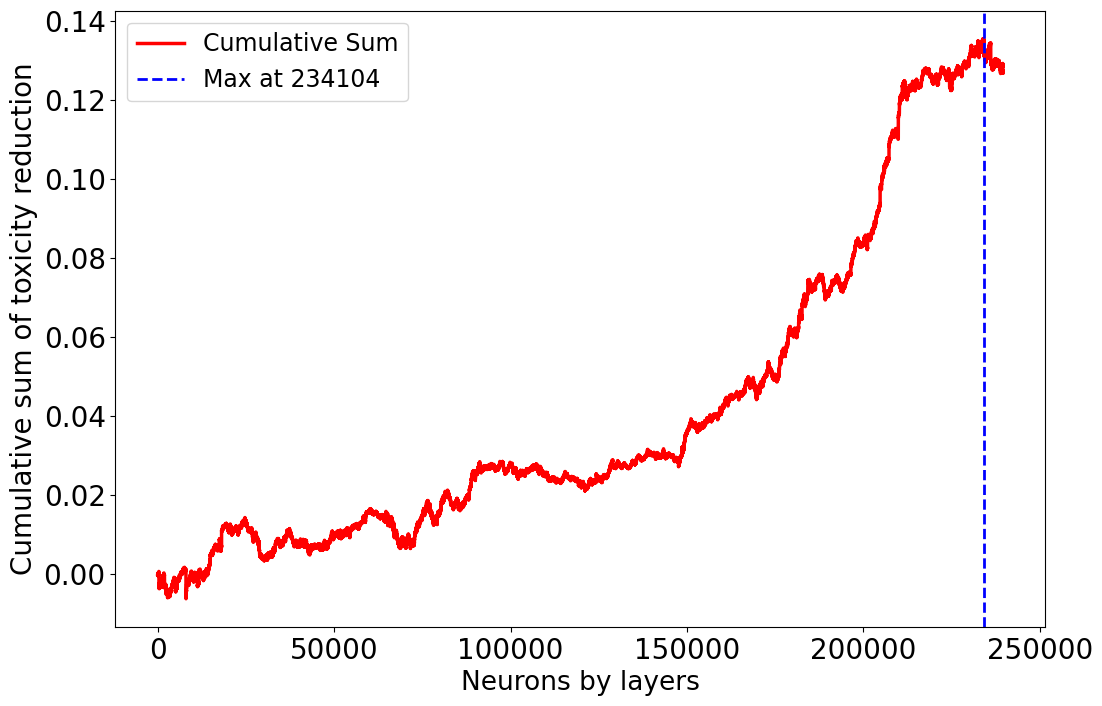

In [6]:
# Initialize an empty list for the cumulative sum
cumsum_values = []

# Manually calculate the cumulative sum
current_sum = 0
for value in df['projection_diff']:
    current_sum += value
    cumsum_values.append(current_sum)

# Find the index where the cumulative sum reaches its maximum
max_cumsum_index = np.argmax(cumsum_values)

# Plot the manually calculated cumulative sum
plt.figure(figsize=(12, 8))
plt.plot(cumsum_values, label='Cumulative Sum', color='r', linewidth=2.5)  # Increased linewidth

# Add a vertical line at the maximum cumulative sum
plt.axvline(x=max_cumsum_index, color='b', linestyle='--', linewidth=2, label=f'Max at {max_cumsum_index}')  # Increased linewidth

# Add labels and title
# plt.title("Cumulative sum of toxicity reduction contributed by neurons", fontsize=18)
plt.xlabel("Neurons by layers", fontsize=19)
plt.ylabel("Cumulative sum of toxicity reduction", fontsize=20)

# Increase tick label sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add legend
plt.legend(fontsize=17)

# Show the plot
# plt.grid(True)
plt.show()

In [11]:
df = df.sort_values(by="projection_diff", ascending=False)

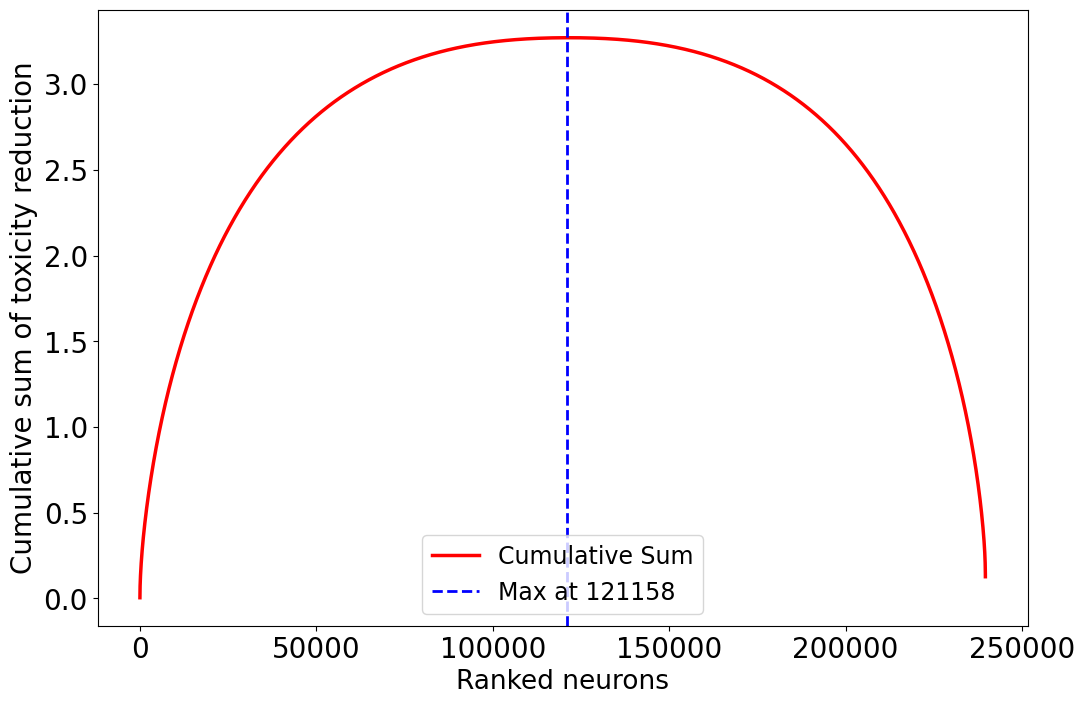

In [12]:
# Initialize an empty list for the cumulative sum
cumsum_values = []

# Manually calculate the cumulative sum
current_sum = 0
for value in df['projection_diff']:
    current_sum += value
    cumsum_values.append(current_sum)

# Find the index where the cumulative sum reaches its maximum
max_cumsum_index = np.argmax(cumsum_values)

# Plot the manually calculated cumulative sum
plt.figure(figsize=(12, 8))
plt.plot(cumsum_values, label='Cumulative Sum', color='r', linewidth=2.5)  # Increased linewidth

# Add a vertical line at the maximum cumulative sum
plt.axvline(x=max_cumsum_index, color='b', linestyle='--', linewidth=2, label=f'Max at {max_cumsum_index}')  # Increased linewidth

# Add labels and title
# plt.title("Cumulative sum of toxicity reduction contributed by neurons", fontsize=18)
plt.xlabel("Ranked neurons", fontsize=19)
plt.ylabel("Cumulative sum of toxicity reduction", fontsize=20)

# Increase tick label sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add legend
plt.legend(fontsize=17)

# Show the plot
# plt.grid(True)
plt.show()

##### Array plot

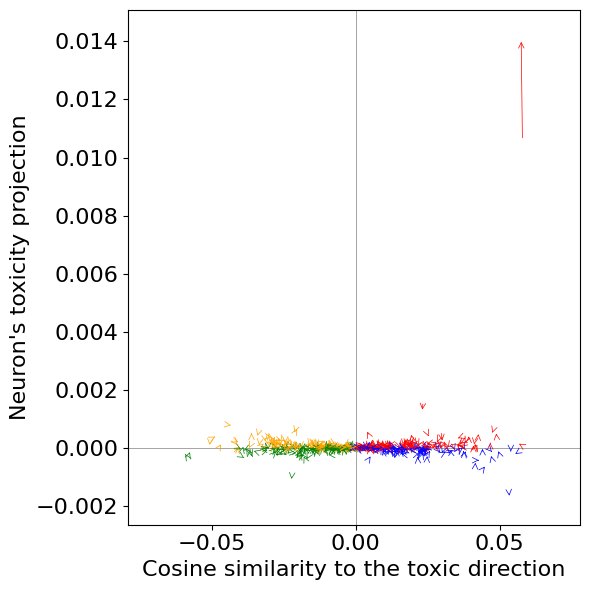

In [17]:
# Top 500 contributing neurons
top_contrib = df[:500]
x1 = top_contrib["pt_cosine_similarity"]
x2 = top_contrib["dpo_cosine_similarity"]
y1 = top_contrib["pt_projection_value"]
y2 = top_contrib["dpo_projection_value"]

fig, ax = plt.subplots(figsize=(6, 6))

# Setting axis labels with larger font size
ax.set_xlabel("Cosine similarity to the toxic direction", fontsize=16)
ax.set_ylabel("Neuron's toxicity projection", fontsize=16)

# Axis limits
_xpad = 0.02
_ypad = 0.001
ax.set_xlim(min(min(x1), min(x2)) - _xpad, max(max(x1), max(x2)) + _xpad)
ax.set_ylim(min(min(y1), min(y2)) - _ypad, max(max(y1), max(y2)) + _ypad)

# Drawing reference lines
ax.axhline(0, color="gray", lw=0.5)
ax.axvline(0, color="gray", lw=0.5)

# Plotting arrows for each contribution
for _x1, _x2, _y1, _y2 in zip(x1, x2, y1, y2):
    if _x1 > 0:
        if _y1 > 0:
            # toxic neuron with positive activation
            color = "r"
        else:
            # toxic neuron with negative activation
            color = "b"
    else:
        if _y1 < 0:
            # anti-toxic neuron with positive activation
            color = "g"
        else:
            # anti-toxic neuron with negative activation
            color = "orange"
    ax.annotate(
        "",
        xy=(_x2, _y2),
        xytext=(_x1, _y1),
        arrowprops=dict(
            arrowstyle="->",
            color=color,
            linewidth=0.5,
        ),
    )

# Increase the size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()

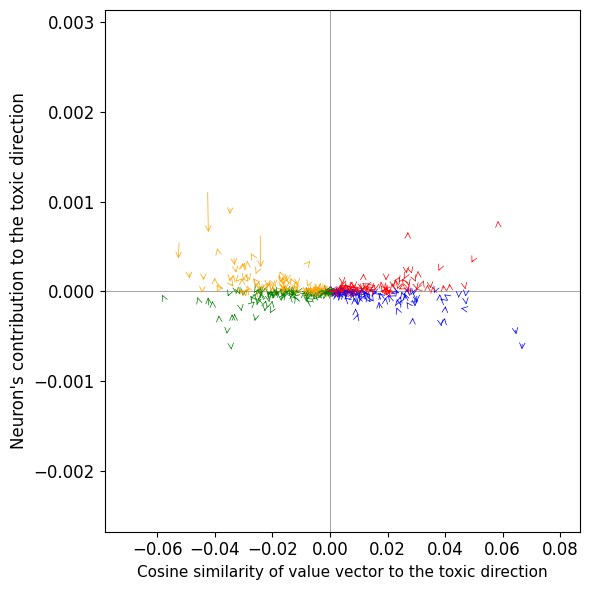

In [18]:
# Top 500 contributing neurons
top_contrib = df[4000:4400]
x1 = top_contrib["pt_cosine_similarity"]
x2 = top_contrib["dpo_cosine_similarity"]
y1 = top_contrib["pt_projection_value"]
y2 = top_contrib["dpo_projection_value"]

fig, ax = plt.subplots(figsize=(6, 6))

# Setting axis labels with larger font size
ax.set_xlabel("Cosine similarity of value vector to the toxic direction", fontsize=11)
ax.set_ylabel("Neuron's contribution to the toxic direction", fontsize=12)

# Axis limits
_xpad = 0.02
_ypad = 0.002
ax.set_xlim(min(min(x1), min(x2)) - _xpad, max(max(x1), max(x2)) + _xpad)
ax.set_ylim(min(min(y1), min(y2)) - _ypad, max(max(y1), max(y2)) + _ypad)

# Drawing reference lines
ax.axhline(0, color="gray", lw=0.5)
ax.axvline(0, color="gray", lw=0.5)

# Plotting arrows for each contribution
for _x1, _x2, _y1, _y2 in zip(x1, x2, y1, y2):
    if _x1 > 0:
        if _y1 > 0:
            # toxic neuron with positive activation
            color = "r"
        else:
            # toxic neuron with negative activation
            color = "b"
    else:
        if _y1 < 0:
            # anti-toxic neuron with positive activation
            color = "g"
        else:
            # anti-toxic neuron with negative activation
            color = "orange"
    ax.annotate(
        "",
        xy=(_x2, _y2),
        xytext=(_x1, _y1),
        arrowprops=dict(
            arrowstyle="->",
            color=color,
            linewidth=0.5,
        ),
    )

# Increase the size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

##### Stacked bar plot

#tp 35040
#tn 25699
#atp 25629
#atn 34791
#total 121159

tp   31%
tn   20%
atp  19%
atn  30%


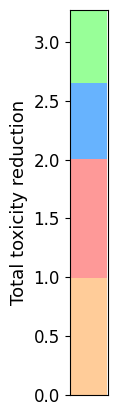

In [19]:
# %%
inc = df[df["projection_diff"] > 0]
# %%
tp = inc[(inc["pt_cosine_similarity"] > 0) & (inc["pt_activation_value"] > 0)]
tn = inc[(inc["pt_cosine_similarity"] > 0) & (inc["pt_activation_value"] <= 0)]
atp = inc[(inc["pt_cosine_similarity"] <= 0) & (inc["pt_activation_value"] > 0)]
atn = inc[(inc["pt_cosine_similarity"] <= 0) & (inc["pt_activation_value"] <= 0)]

print(f"#tp {len(tp)}")
print(f"#tn {len(tn)}")
print(f"#atp {len(atp)}")
print(f"#atn {len(atn)}")
print(f"#total {len(inc)}")
assert len(inc) == len(tp) + len(tn) + len(atp) + len(atn)

tp_sum = tp["projection_diff"].sum()
tn_sum = tn["projection_diff"].sum()
atp_sum = atp["projection_diff"].sum()
atn_sum = atn["projection_diff"].sum()
total_sum = inc["projection_diff"].sum()
print()
print(f"tp   {tp_sum/total_sum:.0%}")
print(f"tn   {tn_sum/total_sum:.0%}")
print(f"atp  {atp_sum/total_sum:.0%}")
print(f"atn  {atn_sum/total_sum:.0%}")


# bar plot of tp
fig, ax = plt.subplots(figsize=(0.5, 5))
ax.bar(0, atn_sum, label="anti-toxic negative", color="#FFCC99")
_b = atn_sum
ax.bar(0, tp_sum, bottom=_b, label="toxic positive", color="#FE9998")
_b += tp_sum
ax.bar(0, tn_sum, bottom=_b, label="toxic negative", color="#67B3FE")
_b += tn_sum
ax.bar(0, atp_sum, bottom=_b, label="anti-toxic positive", color="#98FF98")
_b += atp_sum

# set lim
ax.set_ylim(0, total_sum)
# y axis total group contribution
ax.set_ylabel("Total toxicity reduction", fontsize=13)
# remove x ticks
ax.set_xticks([])
# Increase the size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# axs.append(ax)

##### Per-layer graphs

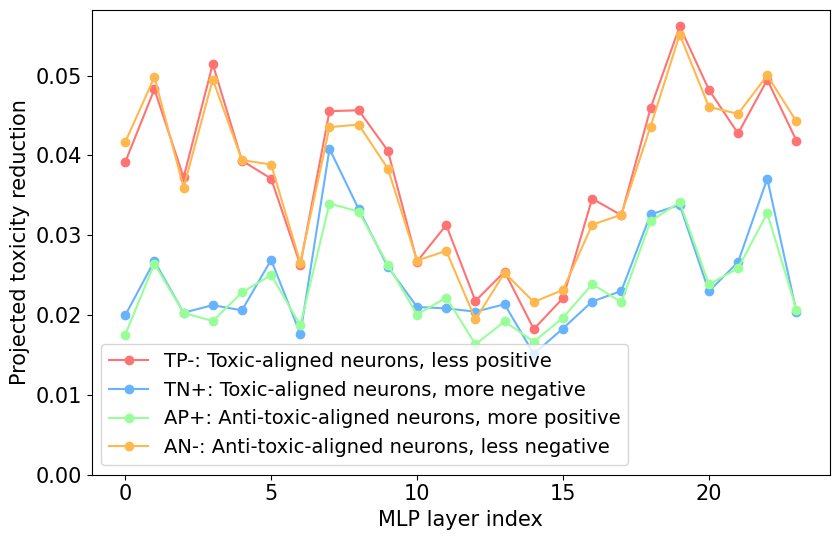

In [25]:
# Define group colors for consistency
colors = ['#FF7373', '#67B3FE', '#98FF98', '#FFB84D']
group_labels = ['toxic positive', 'toxic negative', 'anti-toxic positive', 'anti-toxic negative']

# Initialize lists to store the sums of projection_diff for each group in each layer
tp_sums, tn_sums, atp_sums, atn_sums = [], [], [], []

# Iterate through each layer and compute the projection_diff sums for each group
layers_to_plot = range(24)

for layer in layers_to_plot:
    # Filter neurons by layer
    layer_df = df[df['layer_idx'] == layer]

    # Filter data for positive projection differences
    inc = layer_df[layer_df["projection_diff"] > 0]

    # Apply the same filtering as before
    tp = inc[(inc["pt_cosine_similarity"] > 0) & (inc["pt_activation_value"] > 0)]
    tn = inc[(inc["pt_cosine_similarity"] > 0) & (inc["pt_activation_value"] <= 0)]
    atp = inc[(inc["pt_cosine_similarity"] <= 0) & (inc["pt_activation_value"] > 0)]
    atn = inc[(inc["pt_cosine_similarity"] <= 0) & (inc["pt_activation_value"] <= 0)]
    
    # Calculate the sum of projection_diff for each group in this layer
    tp_sums.append(tp["projection_diff"].sum())
    tn_sums.append(tn["projection_diff"].sum())
    atp_sums.append(atp["projection_diff"].sum())
    atn_sums.append(atn["projection_diff"].sum())

# Prepare data for plotting the lines for each group
fig, ax = plt.subplots(figsize=(8.5, 5.5))

# Plot lines for each group
ax.plot(layers_to_plot, tp_sums, label='TP-: Toxic-aligned neurons, less positive', color=colors[0], marker='o')
ax.plot(layers_to_plot, tn_sums, label='TN+: Toxic-aligned neurons, more negative', color=colors[1], marker='o')
ax.plot(layers_to_plot, atp_sums, label='AP+: Anti-toxic-aligned neurons, more positive', color=colors[2], marker='o')
ax.plot(layers_to_plot, atn_sums, label='AN-: Anti-toxic-aligned neurons, less negative', color=colors[3], marker='o')

# Add a horizontal line at y=0 for clarity
# ax.axhline(y=0, color='black', linestyle='--')

# Set labels and title
ax.set_xlabel('MLP layer index', fontsize=15)
ax.set_ylabel('Projected toxicity reduction', fontsize=15)
# ax.set_title('Toxicity reduction per layer contributed by neuron groups', fontsize=14)

# Add a legend to indicate which line corresponds to which group
ax.legend(fontsize=14)

# Set xticks and yticks with increased font size
ax.set_xticks(range(0, 25, 5))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Define y-axis limits to start from 0
ax.set_ylim(bottom=0)

# Show the plot
plt.tight_layout()
plt.show()

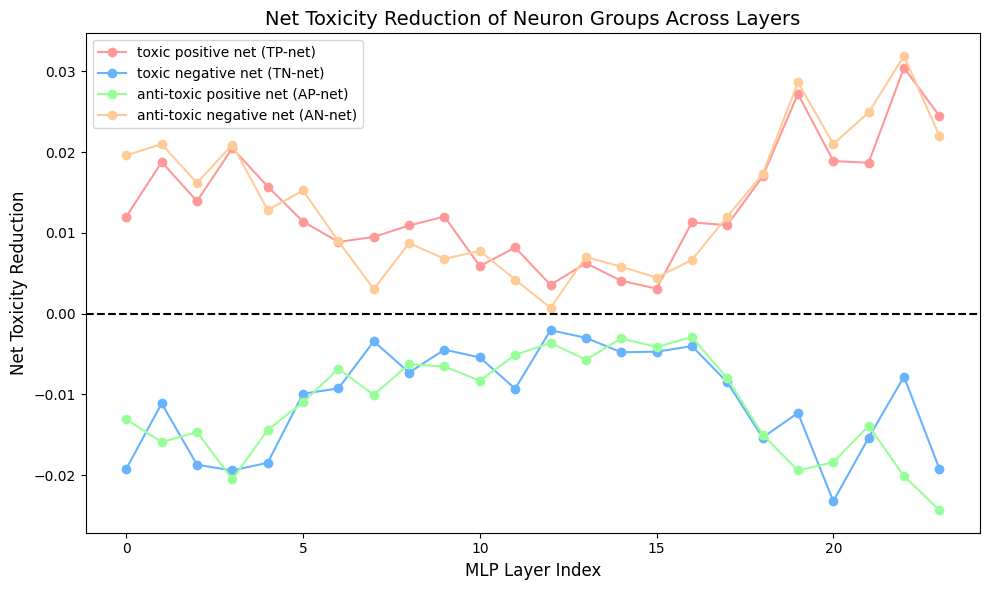

In [26]:
# Define group colors for consistency
colors = ['#FE9998', '#67B3FE', '#98FF98', '#FFCC99']
group_labels = ['toxic positive', 'toxic negative', 'anti-toxic positive', 'anti-toxic negative']

# Initialize lists to store the sums of projection_diff for each group in each layer
tp_sums, tn_sums, atp_sums, atn_sums = [], [], [], []

# Iterate through each layer and compute the projection_diff sums for each group
layers_to_plot = range(24)

for layer in layers_to_plot:
    # Filter neurons by layer
    layer_df = df[df['layer_idx'] == layer]

    # Apply the same filtering as before, but without filtering out projection_diff <= 0
    tp = layer_df[(layer_df["pt_cosine_similarity"] > 0) & (layer_df["pt_activation_value"] > 0)]
    tn = layer_df[(layer_df["pt_cosine_similarity"] > 0) & (layer_df["pt_activation_value"] <= 0)]
    atp = layer_df[(layer_df["pt_cosine_similarity"] <= 0) & (layer_df["pt_activation_value"] > 0)]
    atn = layer_df[(layer_df["pt_cosine_similarity"] <= 0) & (layer_df["pt_activation_value"] <= 0)]

    # Calculate the sum of projection_diff for each group in this layer
    tp_sums.append(tp["projection_diff"].sum())
    tn_sums.append(tn["projection_diff"].sum())
    atp_sums.append(atp["projection_diff"].sum())
    atn_sums.append(atn["projection_diff"].sum())

# Prepare data for plotting the lines for each group
fig, ax = plt.subplots(figsize=(10, 6))

# Plot lines for each group
ax.plot(layers_to_plot, tp_sums, label='toxic positive net (TP-net)', color=colors[0], marker='o')
ax.plot(layers_to_plot, tn_sums, label='toxic negative net (TN-net)', color=colors[1], marker='o')
ax.plot(layers_to_plot, atp_sums, label='anti-toxic positive net (AP-net)', color=colors[2], marker='o')
ax.plot(layers_to_plot, atn_sums, label='anti-toxic negative net (AN-net)', color=colors[3], marker='o')

# Add a horizontal line at y=0 for clarity
ax.axhline(y=0, color='black', linestyle='--')

# Set labels and title
ax.set_xlabel('MLP Layer Index', fontsize=12)
ax.set_ylabel('Net Toxicity Reduction', fontsize=12)
ax.set_title('Net Toxicity Reduction of Neuron Groups Across Layers', fontsize=14)

# Add a legend to indicate which line corresponds to which group
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_2538906/3333071173.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_labels, rotation=45, ha='right', fontsize=12)


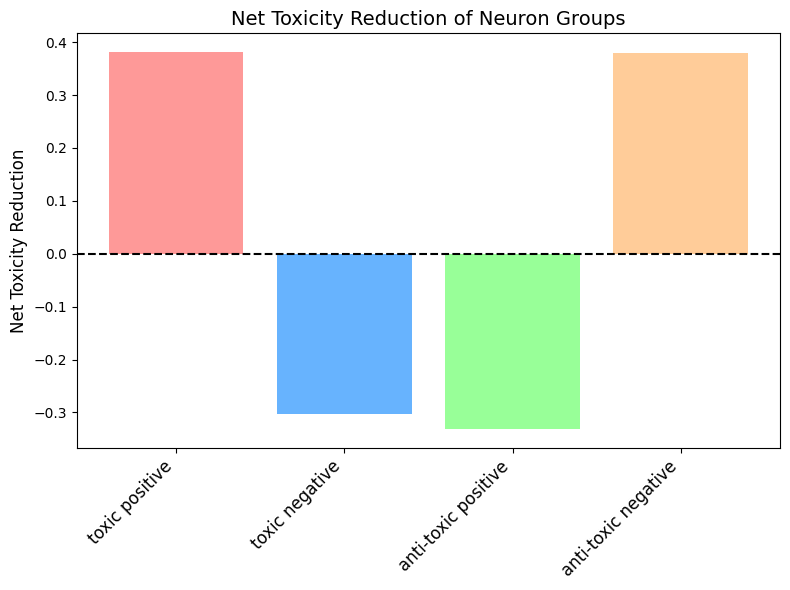

In [27]:
# Calculate the net sums across all layers for the four groups
tp = df[(df["pt_cosine_similarity"] > 0) & (df["pt_activation_value"] > 0)]
tn = df[(df["pt_cosine_similarity"] > 0) & (df["pt_activation_value"] <= 0)]
atp = df[(df["pt_cosine_similarity"] <= 0) & (df["pt_activation_value"] > 0)]
atn = df[(df["pt_cosine_similarity"] <= 0) & (df["pt_activation_value"] <= 0)]

# Calculate the total sum of projection_diff for each group
tp_sum = tp["projection_diff"].sum()
tn_sum = tn["projection_diff"].sum()
atp_sum = atp["projection_diff"].sum()
atn_sum = atn["projection_diff"].sum()

# Prepare data for plotting
group_sums = [tp_sum, tn_sum, atp_sum, atn_sum]
group_labels = ['toxic positive', 'toxic negative', 'anti-toxic positive', 'anti-toxic negative']
colors = ['#FE9998', '#67B3FE', '#98FF98', '#FFCC99']

# Plot the net effect for all neurons across all layers
fig, ax = plt.subplots(figsize=(8, 6))

# Create a bar plot
ax.bar(group_labels, group_sums, color=colors)

# Add a horizontal line at y=0 for clarity
ax.axhline(y=0, color='black', linestyle='--')

# Set labels and title
ax.set_ylabel('Net Toxicity Reduction', fontsize=12)
ax.set_title('Net Toxicity Reduction of Neuron Groups', fontsize=14)

# Rotate x-axis labels for better visibility
ax.set_xticklabels(group_labels, rotation=45, ha='right', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

##### Notes: 
(1) Green is always negative, is it the main tradeoff point?

(2) Blue decreases from positive (top 1 group) to negative, as another tradeoff point?

##### Frequency bar plot

In [31]:
df = merged_df
df = df.sort_values(by="projection_diff", ascending=False)

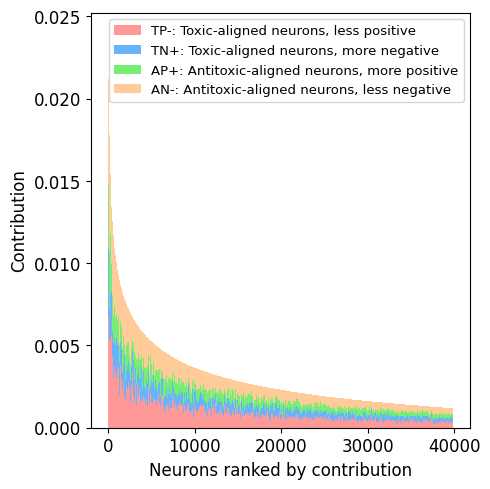

In [32]:
# Top 100-4000 contributing neurons (omit first 100 for better displaying)
chunk_size = 50
tp_contribs = []
tn_contribs = []
atp_contribs = []
atn_contribs = []
for i in range(100, 40000, chunk_size):
    chunk = df[i : i + chunk_size]
    tp = chunk[(chunk["pt_cosine_similarity"] > 0) & (chunk["pt_activation_value"] > 0)]
    tn = chunk[(chunk["pt_cosine_similarity"] > 0) & (chunk["pt_activation_value"] <= 0)]
    atp = chunk[(chunk["pt_cosine_similarity"] <= 0) & (chunk["pt_activation_value"] > 0)]
    atn = chunk[(chunk["pt_cosine_similarity"] <= 0) & (chunk["pt_activation_value"] <= 0)]
    tp_contribs.append(tp["projection_diff"].sum())
    tn_contribs.append(tn["projection_diff"].sum())
    atp_contribs.append(atp["projection_diff"].sum())
    atn_contribs.append(atn["projection_diff"].sum())
    
# bar plot of tp
fig, ax = plt.subplots(figsize=(5, 5))
x = np.arange(len(tp_contribs)) * chunk_size
# adjust width
w = 1.0 * chunk_size

# instead, stack bars one on another
ax.bar(x, tp_contribs, label="TP-: Toxic-aligned neurons, less positive", color="#FE9998", width=w)
_b = np.array(tp_contribs)
ax.bar(x, tn_contribs, bottom=_b, label="TN+: Toxic-aligned neurons, more negative", color="#67B3FE", width=w)
_b += np.array(tn_contribs)
ax.bar(x, atp_contribs, bottom=_b, label="AP+: Antitoxic-aligned neurons, more positive", color="#76EE76", width=w)
_b += np.array(atp_contribs)
ax.bar(x, atn_contribs, bottom=_b, label="AN-: Antitoxic-aligned neurons, less negative", color="#FFCC99", width=w)
ax.legend()

# label axes
ax.set_xlabel("Neurons ranked by contribution", fontsize=12)
ax.set_ylabel("Contribution", fontsize=12)

# Increasing the size of tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Enlarging the legend
ax.legend(fontsize=9.5)

plt.tight_layout()
plt.show()

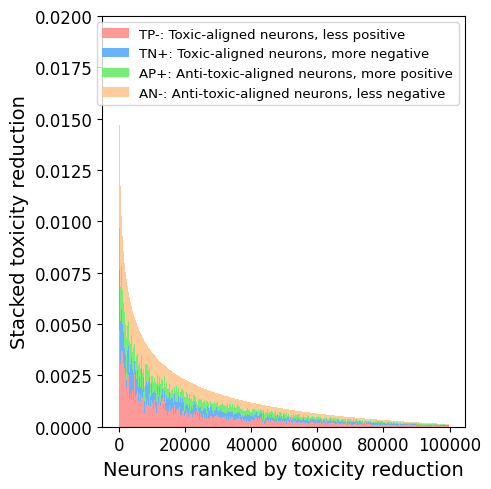

In [33]:
# Top 200-10000 contributing neurons (omit first 100 for better displaying)
chunk_size = 50
tp_contribs = []
tn_contribs = []
atp_contribs = []
atn_contribs = []
for i in range(200, 100000, chunk_size):
    chunk = df[i : i + chunk_size]
    tp = chunk[(chunk["pt_cosine_similarity"] > 0) & (chunk["pt_activation_value"] > 0)]
    tn = chunk[(chunk["pt_cosine_similarity"] > 0) & (chunk["pt_activation_value"] <= 0)]
    atp = chunk[(chunk["pt_cosine_similarity"] <= 0) & (chunk["pt_activation_value"] > 0)]
    atn = chunk[(chunk["pt_cosine_similarity"] <= 0) & (chunk["pt_activation_value"] <= 0)]
    tp_contribs.append(tp["projection_diff"].sum())
    tn_contribs.append(tn["projection_diff"].sum())
    atp_contribs.append(atp["projection_diff"].sum())
    atn_contribs.append(atn["projection_diff"].sum())
    
# bar plot of tp
fig, ax = plt.subplots(figsize=(5, 5))
x = np.arange(len(tp_contribs)) * chunk_size
# adjust width
w = 1.0 * chunk_size

# instead, stack bars one on another
ax.bar(x, tp_contribs, label="TP-: Toxic-aligned neurons, less positive", color="#FE9998", width=w)
_b = np.array(tp_contribs)
ax.bar(x, tn_contribs, bottom=_b, label="TN+: Toxic-aligned neurons, more negative", color="#67B3FE", width=w)
_b += np.array(tn_contribs)
ax.bar(x, atp_contribs, bottom=_b, label="AP+: Anti-toxic-aligned neurons, more positive", color="#76EE76", width=w)
_b += np.array(atp_contribs)
ax.bar(x, atn_contribs, bottom=_b, label="AN-: Anti-toxic-aligned neurons, less negative", color="#FFCC99", width=w)
ax.legend()

# label axes
ax.set_xlabel("Neurons ranked by toxicity reduction", fontsize=14)
ax.set_ylabel("Stacked toxicity reduction", fontsize=14)

# Increasing the size of tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Enlarging the legend
ax.legend(fontsize=9.6)

plt.tight_layout()
plt.show()